In [261]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch_geometric as tgn
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import torch.nn.functional as F

from torch_geometric.loader import DataLoader

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

from tqdm import tqdm

# Model Definition

#### 1 output channel model

In [490]:
class GCN_binary(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_binary, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(30, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # Convolution layers 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # pooling
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # Randomly zeros some values from the input tensor according to a bernouli distribution
        # helps avoid over-fitting by minimizing learned co-dependence of 
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Apply a final classifier
        x = self.lin(x)
        
        return x

#### 2 output channel model

In [403]:
class GCN_2channel_out(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_2channel_out, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(30, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # Convolution layers 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # pooling
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

# Training / Eval Functions

#### 2 output channels

In [392]:
def train_one_epoch_2channels(model, data_loader, optimizer, loss_fn):
    
    model.train()
    loss_sum = []
    for _, batch in enumerate(data_loader):
        optimizer.zero_grad()

        model_out = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = loss_fn(model_out, batch.y)

        loss.backward()  
        optimizer.step()
        
        # metrics
        loss_sum.append(loss.detach().numpy())
        
    return np.array(loss_sum).sum() / len(data_loader)
    

In [393]:
def test_2channels(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x.float(), data.edge_index, data.batch)          
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

#### 1 output channel

In [394]:
def train_one_epoch_1channel(model, data_loader, optimizer, loss_fn):
    model.train()
    loss_sum = []
    for _, batch in enumerate(data_loader):
        optimizer.zero_grad()
        
        model_out = torch.sigmoid(model(batch.x.float(), batch.edge_index, batch.batch))
        loss = loss_fn(torch.squeeze(model_out), batch.y.float())

        loss.backward()  
        optimizer.step()
        
        # metrics
        loss_sum.append(loss.detach().numpy())
        
    return np.array(loss_sum).sum() / len(data_loader)
    

In [395]:
def test_1channel(loader):
    model.eval()
    correct = 0
    for data in loader:        
        out = torch.sigmoid(model(data.x.float(), data.edge_index, data.batch))
        pred = torch.tensor([1.0 if res > 0.5 else 0 for res in out])
        
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

### Helper Methods

In [338]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Message Passing Pyg Experiments

### Rich Dataset

In [446]:
import random
random.seed(1)

In [460]:
rich_data = torch.load('rich_dataset.pt') # 30 node features, 11 edge features

  0%|                                                                                                    | 0/1000 [51:23<?, ?it/s]


In [461]:
rich_data[0]

Data(x=[28, 30], edge_index=[2, 60], edge_attr=[60, 11], y=0)

In [462]:
random.shuffle(rich_data)

In [463]:
train_loader = DataLoader(rich_data[:int(len(rich_data)*0.9)], batch_size=32, shuffle=True)
test_loader = DataLoader(rich_data[int(len(rich_data)*0.9):], batch_size=32, shuffle=True)

## Train
#### Binary Cross Entropy Loss

In [464]:
model = GCN_binary(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCELoss()

In [465]:
print('num model params:', count_parameters(model))

num model params: 10369


In [466]:
epochs = 500

losses = []
test_scores = []
pbar = tqdm(total = epochs, position=0, leave=True)
for epoch in range(epochs):
    losses.append(  
        (  epoch, train_one_epoch_1channel(model, train_loader, optimizer, loss_fn)  )
                 )
    if epoch % 5 == 0:
        test_scores.append((epoch, test_1channel(test_loader)))    
        
    pbar.update(1)
    
pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [14:20<00:00,  1.72s/it]


In [467]:
binary_losses = losses

In [468]:
binary_test_scores = test_scores

In [469]:
binary_losses[-5:]

[(495, 0.20492987199263138),
 (496, 0.20252607518976384),
 (497, 0.1958147569136186),
 (498, 0.20087942643599077),
 (499, 0.20502471923828125)]

In [470]:
binary_test_scores[-10:]

[(450, 0.8512820512820513),
 (455, 0.85),
 (460, 0.8333333333333334),
 (465, 0.8538461538461538),
 (470, 0.8423076923076923),
 (475, 0.8423076923076923),
 (480, 0.8461538461538461),
 (485, 0.8512820512820513),
 (490, 0.8487179487179487),
 (495, 0.8487179487179487)]

In [471]:
binary_model = model

#### Cross Entropy Loss

In [472]:
train_loader = DataLoader(rich_data[:int(len(rich_data)*0.9)], batch_size=32, shuffle=True)
test_loader = DataLoader(rich_data[int(len(rich_data)*0.9):], batch_size=32, shuffle=True)

In [473]:
model = GCN_2channel_out(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

print('num model params:', count_parameters(model))

num model params: 10434


In [474]:
epochs = 500

losses = []
test_scores = []
pbar = tqdm(total = epochs, position=0, leave=True)
for epoch in range(epochs):
    losses.append(  
        (  epoch, train_one_epoch_2channels(model, train_loader, optimizer, loss_fn)  )
                 )
    if epoch % 5 == 0:
        test_scores.append((epoch, test_2channels(test_loader)))    
        
    pbar.update(1)
    
pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [13:28<00:00,  1.62s/it]


In [475]:
losses_2chan = losses
test_scores_2chan = test_scores

In [476]:
model_2chan = model

In [478]:
losses_2chan[-5:]

[(495, 0.21938018798828124),
 (496, 0.2179456364024769),
 (497, 0.2178177920254794),
 (498, 0.2228319688276811),
 (499, 0.21928435238924893)]

In [479]:
test_scores_2chan[-10:]

[(450, 0.8512820512820513),
 (455, 0.8397435897435898),
 (460, 0.8538461538461538),
 (465, 0.85),
 (470, 0.8474358974358974),
 (475, 0.8487179487179487),
 (480, 0.8525641025641025),
 (485, 0.8564102564102564),
 (490, 0.8474358974358974),
 (495, 0.8551282051282051)]

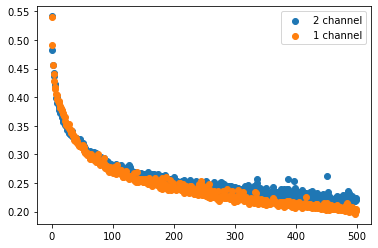

In [482]:
### Vis
losses_2chan = np.array(losses_2chan)
binary_losses = np.array(binary_losses)


plt.scatter(losses_2chan[:,0],losses_2chan[:,1] , label='2 channel')
plt.scatter(binary_losses[:,0],binary_losses[:,1] , label='1 channel')

plt.legend()

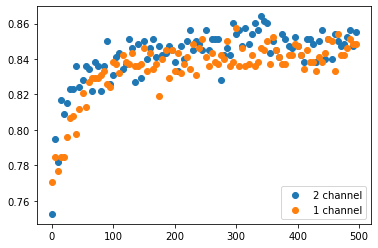

In [483]:
### Vis
test_scores_2chan = np.array(test_scores_2chan)
binary_test_scores = np.array(binary_test_scores)


plt.scatter(test_scores_2chan[:,0],test_scores_2chan[:,1] , label='2 channel')
plt.scatter(binary_test_scores[:,0],binary_test_scores[:,1] , label='1 channel')

plt.legend()

### Hyperparameter exploration

In [ ]:
# test all these hyperparams for Adam and SGD optimizers
lrs = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.1]
channels = [8, 16, 32, 64, 128]

epochs = 75

rich_data = torch.load('rich_dataset.pt') # 30 node features, 11 edge features
random.seed(1)
random.shuffle(rich_data)

train_loader = DataLoader(rich_data[:int(len(rich_data)*0.9)], batch_size=32, shuffle=True)
test_loader = DataLoader(rich_data[int(len(rich_data)*0.9):], batch_size=32, shuffle=True)

total = len(lrs) * len(channels) * epochs
pbar = tqdm(total=total , position=0, leave=True)

res_dict = {}
for lr in lrs:
    
    for n_chans in channels:
        
        model = GCN_binary(hidden_channels=n_chans)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = torch.nn.BCELoss()
        
        losses = []
        test_scores = []
        for epoch in range(epochs):
            losses.append(  
                (  epoch, train_one_epoch_1channel(model, train_loader, optimizer, loss_fn)  )
            )
            if epoch % 5 == 0:
                test_scores.append((epoch, test_1channel(test_loader)))    
            pbar.update(1)
            
        res_dict[str(lr)+'_'+str(n_chans)] = [losses, test_scores]
        
pbar.close() 

 34%|█████████████████████████████▊                                                           | 1005/3000 [24:43<54:01,  1.62s/it]

## Save Model

In [480]:
path = '/Users/maxperozek/CP341/Proj/CP341_B722_GNN/models/'

In [481]:
save = False

model_to_save = binary_model
if save:
    torch.save(model_to_save.state_dict(), path+'GNN_500epoch_state_dict.pt')